In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import lasagne.layers.dnn
import string
import sys
from datetime import datetime, timedelta
import time
import cPickle as pickle
import gzip
import h5py
from ConfusionMatrix import ConfusionMatrix
import matplotlib.pylab as plt
%matplotlib inline

np.random.seed(2345)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5110)


# Prepare train and test dataset

Train: Cullpdb+profile_6133_filtered  (0:5022, 700, 57)  
<br>
Validation:  Cullpdb+profile_6133_filtered   (5022:5534, 700, 57)
<br>

Test:   CB513 (514, 700, 57)        CASP10 (123, 700, 43)

In [2]:
#############################################################################
##### TRAIN DATA Cullpdb+profile_6133_filtered #####
############################################################################
time_start = time.time()
print("Loading train data (Cullpdb_filted)...")
X_in = np.load(gzip.open('data/cullpdb+profile_6133_filtered.npy.gz', 'rb'))
X = np.reshape(X_in,(5534,700,57))
del X_in

# for joint learning
labels_1 = X[:, :, 22:30]    # secondary struture label
labels_2 = X[:, :, 33:35]   # solvent accessibility label
####
mask = 1 - X[:, :, 30] 
feature_index = np.hstack((np.arange(0,21),np.arange(35,56)))  # 42-d features
X = X[ :, :, feature_index]

# getting meta
num_seqs, seqlen, feature_dim = np.shape(X)
num_classes = 8

X = X.astype(theano.config.floatX)
mask = mask.astype(theano.config.floatX)
vals = np.arange(0,8)

# secondary structure label
labels_new_1 = np.zeros((num_seqs,seqlen))
for i in xrange(np.size(labels_1,axis=0)):
    labels_new_1[i,:] = np.dot(labels_1[i,:,:], vals)
labels_new_1 = labels_new_1.astype('int32')
labels_1 = labels_new_1

# solvent accessibility label
labels_new_2 = np.zeros((num_seqs, seqlen))
vals2 = np.array([2, 1])
for i in xrange(np.size(labels_2,axis=0)):
    labels_new_2[i,:] = np.dot(labels_2[i,:,:], vals2)
labels_new_2 = labels_new_2.astype('int32')
labels_2 = labels_new_2

seq_names = np.arange(0, num_seqs)
np.random.shuffle(seq_names)
X_train = X[seq_names[0:5022]]
labels_1_train = labels_1[seq_names[0:5022]]
labels_2_train = labels_2[seq_names[0:5022]]
mask_train = mask[seq_names[0:5022]]

# Using padding for batch usage
X_add = np.zeros((98, seqlen, feature_dim))
label_add = np.zeros((98, seqlen))
mask_add = np.zeros((98, seqlen))

X_train = np.concatenate((X_train,X_add), axis=0).astype(theano.config.floatX)
labels_1_train = np.concatenate((labels_1_train, label_add), axis=0).astype('int32')
labels_2_train = np.concatenate((labels_2_train, label_add), axis=0).astype('int32')
mask_train = np.concatenate((mask_train, mask_add), axis=0).astype('uint8')

print "Train data shape is", X_train.shape, ", two labels shapes are", labels_1_train.shape, \
"and", labels_2_train.shape, ", mask shape is", mask_train.shape, "\n"



####################################################################
##### Validation DATA #####
###################################################################
X_valid = X[seq_names[5022:5534]]
labels_1_valid = labels_1[seq_names[5022:5534]]
labels_2_valid = labels_2[seq_names[5022:5534]]
mask_valid = mask[seq_names[5022:5534]]

print "Validation data shape is", X_valid.shape, ", two labels shapes are", labels_1_valid.shape, \
"and", labels_2_valid.shape, ", mask shape is", mask_valid.shape, "\n"

###########################################################################
##### CB513 Test DATA #####
##########################################################################
print("Loading Test data (CB513)...")
X_in = np.load(gzip.open('data/cb513+profile_split1.npy.gz', 'rb'))
X1 = np.reshape(X_in,(514,700,57))
X = X1
del X_in, X1

# for joint learning
labels_1 = X[:, :, 22:30] # secondary struture label
labels_2 = X[:, :, 33:35] # solvent accessibility label
####
mask = 1 - X[:,:,30]

feature_index = np.hstack((np.arange(0,21),np.arange(35,56)))  # 42-d features
X = X[ :, :, feature_index]

# getting meta
num_seqs, seqlen, feature_dim = np.shape(X)
num_classes = 8

X = X.astype(theano.config.floatX)
mask = mask.astype(theano.config.floatX)
vals = np.arange(0,8)

# secondary structure label
labels_new_1 = np.zeros((num_seqs, seqlen))
for i in xrange(np.size(labels_1,axis=0)):
    labels_new_1[i,:] = np.dot(labels_1[i,:,:], vals)
labels_new_1 = labels_new_1.astype('int32')
labels_1 = labels_new_1
# solvent accessibility label
labels_new_2 = np.zeros((num_seqs,seqlen))
vals2 = np.array([2, 1])
for i in xrange(np.size(labels_2,axis=0)):
    labels_new_2[i,:] = np.dot(labels_2[i,:,:], vals2)
labels_new_2 = labels_new_2.astype('int32')
labels_2 = labels_new_2

# When test, we use batch_size = 1, so there is no need for padding
X_test_cb513 = X
labels_1_test_cb513 = labels_1
labels_2_test_cb513 = labels_2
mask_test_cb513 = mask.astype('uint8')

print "Test data shape is", X_test_cb513.shape, ", two labels shapes are", labels_1_test_cb513.shape, \
"and", labels_2_test_cb513.shape, ", mask shape is", mask_test_cb513.shape, "\n"

###############################################################################
# CASP10
##############################################################################
print("Loading Test data (CASP10)...")
casp10 = h5py.File("data/casp10.h5")
casp10_feature = casp10['features'][:, :, 0:42].astype("float32")

casp10_labels_1 = casp10['labels'][:, :, 0:8]
num_seqs, seqlen, feature_dim = np.shape(casp10_feature)
num_classes = 8
vals = np.arange(0,8)
# secondary structure label
labels_new_1 = np.zeros((num_seqs, seqlen))
for i in xrange(num_seqs):
    labels_new_1[i,:] = np.dot(casp10_labels_1[i,:,:], vals)
casp10_labels_1 = labels_new_1.astype('int32')

casp10_mask = 1-casp10['features'][:, :, -1].astype('uint8')


print "casp10 data shape is", casp10_feature.shape, ", labels shape is", casp10_labels_1.shape, \
", mask shape is",  casp10_mask.shape, "\n"

print "load all data takes time %fs" %(time.time()- time_start)

Loading train data (Cullpdb_filted)...
Train data shape is (5120, 700, 42) , two labels shapes are (5120, 700) and (5120, 700) , mask shape is (5120, 700) 

Validation data shape is (512, 700, 42) , two labels shapes are (512, 700) and (512, 700) , mask shape is (512, 700) 

Loading Test data (CB513)...
Test data shape is (514, 700, 42) , two labels shapes are (514, 700) and (514, 700) , mask shape is (514, 700) 

Loading Test data (CASP10)...
casp10 data shape is (123, 700, 42) , labels shape is (123, 700) , mask shape is (123, 700) 

load all data takes time 7.835487s


# Define pipeline, loss and compile

In [3]:
###############################################################
#### define pipeline ##########################################
###############################################################
# 1. Input layer
l_in_1 = lasagne.layers.InputLayer(shape=(None, 700, 21))
l_in_2 = lasagne.layers.InputLayer(shape=(None, 700, 21))

# 1_1. Encode first 21 one-hot vector Layer and the concatenate with the last 21
l_reshape_a1 = lasagne.layers.ReshapeLayer(l_in_1, (-1, 21))
l_reshape_a2 = lasagne.layers.ReshapeLayer(l_in_2, (-1, 21))  

l_in_1_embed = lasagne.layers.DenseLayer(l_reshape_a1, num_units=50, nonlinearity=lasagne.nonlinearities.rectify)
l_1 = lasagne.layers.ConcatLayer(incomings=[l_in_1_embed, l_reshape_a2], axis=1)  

l_in = lasagne.layers.ReshapeLayer(l_1, (-1, 1, 700, 21+50))

# multi-CNN
# kernel_size = 3
l_conv_a = lasagne.layers.Conv2DLayer(incoming=l_in, num_filters=64, pad= (3//2, 0),
                                             filter_size=(3, 21+50), stride=1, nonlinearity=lasagne.nonlinearities.rectify)
l_conv_a1 = lasagne.layers.DimshuffleLayer(l_conv_a, (0,2,1,3))
l_conv_a2 = lasagne.layers.ReshapeLayer(l_conv_a1, (-1, 700, 64))
l_conv_a2 = lasagne.layers.batch_norm(l_conv_a2)

# kernel_size = 7
l_conv_b = lasagne.layers.Conv2DLayer(incoming=l_in, num_filters=64, pad= (7//2, 0),
                                             filter_size=(7, 21+50), stride=1, nonlinearity=lasagne.nonlinearities.rectify)
l_conv_b1 = lasagne.layers.DimshuffleLayer(l_conv_b, (0,2,1,3))
l_conv_b2 = lasagne.layers.ReshapeLayer(l_conv_b1, (-1, 700, 64))
l_conv_b2 = lasagne.layers.batch_norm(l_conv_b2)
# kernel_size = 11
l_conv_c = lasagne.layers.Conv2DLayer(incoming=l_in, num_filters=64, pad= (11//2, 0),
                                             filter_size=(11, 21+50), stride=1, nonlinearity=lasagne.nonlinearities.rectify)
l_conv_c1 = lasagne.layers.DimshuffleLayer(l_conv_c, (0,2,1,3))
l_conv_c2 = lasagne.layers.ReshapeLayer(l_conv_c1, (-1, 700, 64))
l_conv_c2 = lasagne.layers.batch_norm(l_conv_c2)

l_c_a = lasagne.layers.ConcatLayer([l_conv_a2, l_conv_b2, l_conv_c2], axis=2) 
l_c_a_bn = lasagne.layers.batch_norm(l_c_a)
# 3. GRU Layers
# first GRU
l_forward1 = lasagne.layers.GRULayer(lasagne.layers.dropout(l_c_a_bn, p=0.5), 300)
l_backward1 = lasagne.layers.GRULayer(lasagne.layers.dropout(l_c_a_bn, p=0.5), 300, backwards=True) 
l_bgru1 = lasagne.layers.ConcatLayer(incomings=[l_forward1, l_backward1], axis=2) 

# second GRU 
l_forward2 = lasagne.layers.GRULayer(lasagne.layers.dropout(l_bgru1, p=0.5), 300)
l_backward2 = lasagne.layers.GRULayer(lasagne.layers.dropout(l_bgru1, p=0.5), 300, backwards=True)
l_bgru2 = lasagne.layers.ConcatLayer(incomings=[l_forward2, l_backward2], axis=2) 

# third GRU
l_forward3 = lasagne.layers.GRULayer(lasagne.layers.dropout(l_bgru2, p=0.5), 300)
l_backward3 = lasagne.layers.GRULayer(lasagne.layers.dropout(l_bgru2, p=0.5), 300, backwards=True) 

# Concat layer + local (contributution)
l_sum = lasagne.layers.ConcatLayer(incomings=[l_forward3, l_backward3, l_c_a], axis=2) # add local context l_dim_b or l_c_b

# 4. Second Dense Layer
l_reshape_b = lasagne.layers.ReshapeLayer(l_sum, (-1, 300+300+64+64+64))

# multi-output through joint feature learning, add two layers FC layers, mayer using Layer Normalization here as LN is better for FC layers
l_2 = lasagne.layers.DenseLayer(lasagne.layers.dropout(l_reshape_b, p=0.5), num_units=300, nonlinearity=lasagne.nonlinearities.rectify)

l_3 = lasagne.layers.DenseLayer(lasagne.layers.dropout(l_2, p=0.5), num_units=300, nonlinearity=lasagne.nonlinearities.rectify)

# 5. Output Layer
l_recurrent_out1 = lasagne.layers.DenseLayer( l_3, num_units=8, nonlinearity=lasagne.nonlinearities.softmax) # SS output
l_recurrent_out2 = lasagne.layers.DenseLayer( l_3, num_units=4, nonlinearity=lasagne.nonlinearities.softmax)           # SA output

# Now, reshape the output back to the RNN format
l_out_1 = lasagne.layers.ReshapeLayer( l_recurrent_out1, (-1, 700, 8))
l_out_2 = lasagne.layers.ReshapeLayer( l_recurrent_out2, (-1, 700, 4))

l_out = lasagne.layers.ConcatLayer(incomings=[l_out_1, l_out_2], axis=2)

In [4]:
################################################################
#### Compile model
################################################################
sym_y_1 = T.imatrix('target_output_8')
sym_y_2 = T.imatrix('target_output_4')
sym_mask = T.imatrix('mask')
sym_x_1 = T.tensor3(name='feature_one_hot', dtype='float32')
sym_x_2 = T.tensor3(name='feature_float', dtype='float32')

TOL = 1e-5

print("Building network ...")

##########################DEBUG##########################
all_layers = lasagne.layers.get_all_layers(l_out)
num_params = lasagne.layers.count_params(l_out)
print("  number of parameters: %d" % num_params)
print("  layer output shapes:")
for layer in all_layers:
    name = string.ljust(layer.__class__.__name__, 32)
    print("    %s %s" % (name, lasagne.layers.get_output_shape(layer)))
print("Creating cost function")
# lasagne.layers.get_output produces a variable for the output of the net
out_train = lasagne.layers.get_output(l_out, {l_in_1: sym_x_1, l_in_2: sym_x_2}, 
                                      mask=sym_mask, deterministic=False)
out_eval = lasagne.layers.get_output(l_out, {l_in_1: sym_x_1, l_in_2: sym_x_2}, 
                                     mask=sym_mask, deterministic=True)

ss = out_train[:,:,0:8].reshape((-1, 8))
sa = out_train[:,:,8:12].reshape((-1, 4))
#probs_flat = out_train.reshape((-1, num_classes))

lambda_reg = 0.0001
params = lasagne.layers.get_all_params(l_out, regularizable=True)
reg_term = sum(T.sum(p**2) for p in params)
######### calculate cost function #######
cost11 = T.nnet.categorical_crossentropy(T.clip(ss, TOL, 1-TOL), sym_y_1.flatten())
cost21 = T.nnet.categorical_crossentropy(T.clip(sa, TOL, 1-TOL), sym_y_2.flatten())

cost1 = T.sum(cost11*sym_mask.flatten()) / T.sum(sym_mask)
cost2 = T.sum(cost21*sym_mask.flatten()) / T.sum(sym_mask)

cost = cost1 + cost2 + lambda_reg * reg_term

# Retrieve all parameters from the network
all_params = lasagne.layers.get_all_params(l_out, trainable=True)
# Compute SGD updates for training
print("Computing updates ...")
#learning_rate = theano.shared(0.001)
all_grads = T.grad(cost, all_params)
updates, norm_calc = lasagne.updates.total_norm_constraint(all_grads, max_norm=15, return_norm=True)
updates = lasagne.updates.adam(updates, all_params, learning_rate=0.001)


print("Compiling functions ...")
t_compile = time.time()
train = theano.function( [sym_x_1, sym_x_2, sym_y_1, sym_y_2, sym_mask], 
                        [cost1, cost2, cost, out_train, norm_calc], 
                        updates=updates, allow_input_downcast=True)

eval = theano.function([sym_x_1, sym_x_2, sym_y_1, sym_y_2, sym_mask], 
                       [cost1, cost2, cost, out_eval], 
                       allow_input_downcast=True)

print "compile time %fs" %(time.time()-t_compile)

Building network ...
  number of parameters: 4572528
  layer output shapes:
    InputLayer                       (None, 700, 21)
    ReshapeLayer                     (None, 21)
    DenseLayer                       (None, 50)
    InputLayer                       (None, 700, 21)
    ReshapeLayer                     (None, 21)
    ConcatLayer                      (None, 71)
    ReshapeLayer                     (None, 1, 700, 71)
    Conv2DLayer                      (None, 64, 700, 1)
    DimshuffleLayer                  (None, 700, 64, 1)
    ReshapeLayer                     (None, 700, 64)
    BatchNormLayer                   (None, 700, 64)
    Conv2DLayer                      (None, 64, 700, 1)
    DimshuffleLayer                  (None, 700, 64, 1)
    ReshapeLayer                     (None, 700, 64)
    BatchNormLayer                   (None, 700, 64)
    Conv2DLayer                      (None, 64, 700, 1)
    DimshuffleLayer                  (None, 700, 64, 1)
    ReshapeLayer      

/home/zli/anaconda/lib/python2.7/site-packages/Lasagne-0.2.dev1-py2.7.egg/lasagne/layers/helper.py:212: UserWarning: get_output() was called with unused kwargs:
	mask
  % "\n\t".join(suggestions))


# Training, validation and testing

In [5]:
def confmatrix(out, label, mask, num_classes):
    mask1 = np.zeros(mask.shape, dtype=np.bool)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            mask1[i][j] = mask[i][j]

    confmatrix = ConfusionMatrix(num_classes)
    mask_flat = mask1.flatten()
    out_preds = np.argmax(out, axis=2).flatten()
    label1 = label.flatten()
    confmatrix.batchAdd(label1[mask_flat], out_preds[mask_flat])
    return confmatrix

In [6]:
train_epochs = 200
valid_epoch = 5
test_epoch = 20

train_batch_size = 128
valid_batch_size = 32
test_batch_size = 1

train_batches = X_train.shape[0]//train_batch_size
valid_batches = X_valid.shape[0]//valid_batch_size
test_cb513_batch = X_test_cb513.shape[0]//test_batch_size
test_casp10_batch = casp10_feature.shape[0]//test_batch_size


all_losses_train_1 = []
all_losses_train_2 = []
all_losses_train = []
all_accuracy_train_1 = []
all_accuracy_train_2 = []
all_confusion_matrix_train_1 = []
all_confusion_matrix_train_2 = []

all_losses_valid_1 = []
all_losses_valid_2 = []
all_losses_valid = []
all_accuracy_valid_1 = []
all_accuracy_valid_2 = []
all_confusion_matrix_valid_1 = []
all_confusion_matrix_valid_2 = []

all_losses_cb513_1 = []
all_losses_cb513_2 = []
all_losses_cb513 = []
all_accuracy_cb513_1 = []
all_accuracy_cb513_2 = []
all_confusion_matrix_cb513_1 = []
all_confusion_matrix_cb513_2 = []
all_prediction_cb513 = []

all_losses_casp10_1 = []
all_accuracy_casp10_1 = []
all_confusion_matrix_casp10_1 = []
all_prediction_casp10 = []


for i in xrange(train_epochs):
    if (i%10) == 0:
        print "Epoch %d of %d" %(i+1, train_epochs)
    
    seq_index = np.arange(X_train.shape[0])
    np.random.shuffle(seq_index)
    X_train_in1_all = X_train[seq_index, :, 0:21]
    X_train_in2_all = X_train[seq_index, :, 21:42]
    labels_train_in1_all = labels_1_train[seq_index]
    labels_train_in2_all = labels_2_train[seq_index]
    mask_train_in_all = mask_train[seq_index]    
    
    losses1 = []
    losses2 = []
    losses = []
    preds1 = []
    preds2 = []
    norms = []
    
    train_one_epoch_start = time.time()
    for j in xrange(X_train.shape[0]//train_batch_size):
        idx = range(j*train_batch_size, (j+1)*train_batch_size)

        X_train_in1 = X_train_in1_all[idx]
        X_train_in2 = X_train_in2_all[idx]
        labels_train_in1 = labels_train_in1_all[idx]
        labels_train_in2 = labels_train_in2_all[idx]
        mask_train_in = mask_train_in_all[idx]
        
        loss1, loss2, loss, out, batch_norm = train(X_train_in1, X_train_in2, \
                                                    labels_train_in1, labels_train_in2, mask_train_in)
        
        #print "%dth mini-batch loss is %f" %(j, loss)
        norms.append(batch_norm)
        preds1.append(out[:,:,0:8])  
        preds2.append(out[:,:,8:12])
        losses1.append(loss1)
        losses2.append(loss2)
        losses.append(loss)
    
    #######################################################
    ### just for training process monitor
    ######################################################
    predictions1 = np.concatenate(preds1, axis = 0)
    predictions2 = np.concatenate(preds2, axis = 0)

    loss_train_1 = np.mean(losses1)
    loss_train_2 = np.mean(losses2)
    loss_train = np.mean(losses)
    
    all_losses_train_1.append(loss_train_1)
    all_losses_train_2.append(loss_train_2)
    all_losses_train.append(loss_train)
    
    confmatrix1 = confmatrix(predictions1, labels_train_in1_all, mask_train_in_all, 8)
    confmatrix2 = confmatrix(predictions2, labels_train_in2_all, mask_train_in_all, 4)

    all_accuracy_train_1.append(confmatrix1.accuracy())
    all_accuracy_train_2.append(confmatrix2.accuracy())
    all_confusion_matrix_train_1.append(confmatrix1)
    all_confusion_matrix_train_2.append(confmatrix2)
    
    print "One epoch training cost time %fs" %(time.time()- train_one_epoch_start)
    print "%dth training epoch totally loss is %f" %(i, all_losses_train[i])
    print "%dth training epoch secondary structure Q8 mean accuracy is %f" %(i, all_accuracy_train_1[-1])
    print "%dth training epoch solvent accessibility Q4 mean accuracy is %f" %(i, all_accuracy_train_2[-1])
    
    # every m epoch do validation
    if (i+1)%valid_epoch == 0:
        #print X_valid.shape[0]
        seq_index = np.arange(X_valid.shape[0])
        np.random.shuffle(seq_index)
        
        X_valid_in1_all = X_valid[seq_index, :, 0:21]
        X_valid_in2_all = X_valid[seq_index, :, 21:42]
        labels_valid_in1_all = labels_1_valid[seq_index]
        labels_valid_in2_all = labels_2_valid[seq_index]
        mask_valid_in_all = mask_valid[seq_index]   
    
        losses1 = []
        losses2 = []
        losses = []
        preds1 = []
        preds2 = []
    
        valid_one_epoch_start = time.time()
        for j in xrange(X_valid.shape[0]//valid_batch_size):
            idx = range(j*valid_batch_size, (j+1)*valid_batch_size)
            
            X_valid_in1 = X_valid_in1_all[idx]
            X_valid_in2 = X_valid_in2_all[idx]
            labels_valid_in1 = labels_valid_in1_all[idx]
            labels_valid_in2 = labels_valid_in2_all[idx]
            mask_valid_in = mask_valid_in_all[idx]

            loss1, loss2, loss, out = eval(X_valid_in1, X_valid_in2, labels_valid_in1, labels_valid_in2, mask_valid_in)

            #print "%dth mini-batch loss is %f" %(j, loss)
            preds1.append(out[:,:,0:8])  
            preds2.append(out[:,:,8:12])
            losses1.append(loss1)
            losses2.append(loss2)
            losses.append(loss)

        #######################################################
        ### just for validation process monitor
        ######################################################
        predictions1 = np.concatenate(preds1, axis = 0)
        predictions2 = np.concatenate(preds2, axis = 0)

        loss_valid_1 = np.mean(losses1)
        loss_valid_2 = np.mean(losses2)
        loss_valid = np.mean(losses)

        all_losses_valid_1.append(loss_valid_1)
        all_losses_valid_2.append(loss_valid_2)
        all_losses_valid.append(loss_valid)

        confmatrix1 = confmatrix(predictions1, labels_valid_in1_all, mask_valid_in_all, 8)
        confmatrix2 = confmatrix(predictions2, labels_valid_in2_all, mask_valid_in_all, 4)

        all_accuracy_valid_1.append(confmatrix1.accuracy())
        all_accuracy_valid_2.append(confmatrix2.accuracy())
        all_confusion_matrix_valid_1.append(confmatrix1)
        all_confusion_matrix_valid_2.append(confmatrix2)

        print "One epoch validation cost time %fs" %(time.time()- valid_one_epoch_start)
        print "%dth validation epoch secondary structure Q8 mean accuracy is %f" %(i, all_accuracy_valid_1[-1])
        print "%dth validation epoch solvent accessibility Q4 mean accuracy is %f" %(i, all_accuracy_valid_2[-1]), "\n"
        
    # every test_epoch epoch do cb513 test
    if (i+1)%test_epoch == 0:
        cb513_batches_index = np.arange(test_cb513_batch)
    
        losses1 = []
        losses2 = []
        losses = []
        preds1 = []
        preds2 = []
    
        cb513_one_epoch_start = time.time()
        for j in xrange(X_test_cb513.shape[0]):
            X_cb513_in1 = X_test_cb513[j:j+1, :, 0:21]
            X_cb513_in2 = X_test_cb513[j:j+1, :, 21:42]
            labels_cb513_in1 = labels_1_test_cb513[j:j+1, :]
            labels_cb513_in2 = labels_2_test_cb513[j:j+1, :]
            mask_cb513_in = mask_test_cb513[j:j+1, :]

            loss1, loss2, loss, out = eval(X_cb513_in1, X_cb513_in2, labels_cb513_in1, labels_cb513_in2, mask_cb513_in)

            #print "%dth mini-batch loss is %f" %(j, loss)
            preds1.append(out[:,:,0:8])  
            preds2.append(out[:,:,8:12])
            losses1.append(loss1)
            losses2.append(loss2)
            losses.append(loss)

        #######################################################
        ### just for test cb513 process monitor
        ######################################################
        predictions1 = np.concatenate(preds1, axis = 0)
        predictions2 = np.concatenate(preds2, axis = 0)

        loss_cb513_1 = np.mean(losses1)
        loss_cb513_2 = np.mean(losses2)
        loss_cb513 = np.mean(losses)

        all_losses_cb513_1.append(loss_cb513_1)
        all_losses_cb513_2.append(loss_cb513_2)
        all_losses_cb513.append(loss_cb513)

        confmatrix1 = confmatrix(predictions1, labels_1_test_cb513, mask_test_cb513, 8)
        confmatrix2 = confmatrix(predictions2, labels_2_test_cb513, mask_test_cb513, 4)

        all_accuracy_cb513_1.append(confmatrix1.accuracy())
        all_accuracy_cb513_2.append(confmatrix2.accuracy())
        all_confusion_matrix_cb513_1.append(confmatrix1)
        all_confusion_matrix_cb513_2.append(confmatrix2)
        all_prediction_cb513.append(predictions1)

        print "One epoch cb513 test cost time %fs" %(time.time()- cb513_one_epoch_start)
        print "%dth cb513 test epoch secondary structure Q8 mean accuracy is %f" %(i, all_accuracy_cb513_1[-1])
        print "%dth cb513 test epoch solvent accessibility Q4 mean accuracy is %f" %(i, all_accuracy_cb513_2[-1])
        
        ################################################################################################################
        ##############  CASP10 dataset ###############################
        ##############################################################
        casp10_batches_index = np.arange(test_casp10_batch)

        losses1 = []
        preds1 = []

        casp10_one_epoch_start = time.time()
        for j in xrange(casp10_feature.shape[0]):

            X_casp10_in1 = casp10_feature[j:j+1, :, 0:21]
            X_casp10_in2 = casp10_feature[j:j+1, :, 21:42]
            labels_casp10_in1 = casp10_labels_1[j:j+1, :]
            labels_casp10_in2 = np.zeros_like(labels_casp10_in1)
            labels_casp10_in2 = labels_casp10_in2.astype("uint8")
            mask_casp10_in = casp10_mask[j:j+1, :]

            loss1, loss2, loss, out = eval(X_casp10_in1, X_casp10_in2, labels_casp10_in1, labels_casp10_in2, mask_casp10_in)

            #print "%dth mini-batch loss is %f" %(j, loss)
            preds1.append(out[:,:,0:8])  
            losses1.append(loss1)

        #######################################################
        ### just for testing process monitor
        ######################################################
        predictions1 = np.concatenate(preds1, axis = 0)
        loss_casp10_1 = np.mean(losses1)
        all_losses_casp10_1.append(loss_casp10_1)
        confmatrix1 = confmatrix(predictions1, casp10_labels_1, casp10_mask, 8)
        all_accuracy_casp10_1.append(confmatrix1.accuracy())
        all_confusion_matrix_casp10_1.append(confmatrix1)
        all_prediction_casp10.append(predictions1)

        print "One epoch casp10 test cost time %fs" %(time.time()- casp10_one_epoch_start)
        print "%dth casp10 test epoch secondary structure Q8 mean accuracy is %f" %(i, all_accuracy_casp10_1[-1])
        
        #######################################################
        ### save itermediate parameters
        ######################################################
        
        with open(("./train_models/" + "train-%d" %(i) + ".pkl"), 'w') as f:
            pickle.dump({

                    'param_values': lasagne.layers.get_all_param_values(l_out),

                    'losses_train1': all_losses_train_1,
                    'losses_train2': all_losses_train_2,
                    'losses_train': all_losses_train,
                    'accuracy_train1': all_accuracy_train_1,
                    'accuracy_train2': all_accuracy_train_2,
                    'confusion_matrix_train_1': all_confusion_matrix_train_1,
                    'confusion_matrix_train_2': all_confusion_matrix_train_2,

                    'losses_eval_valid1': all_losses_valid_1,
                    'losses_eval_valid2': all_losses_valid_2,
                    'losses_eval_valid': all_losses_valid,
                    'accuracy_eval_valid1': all_accuracy_valid_1,
                    'accuracy_eval_valid2': all_accuracy_valid_2,
                    'confusion_matrix_valid_1': all_confusion_matrix_valid_1,
                    'confusion_matrix_valid_2': all_confusion_matrix_valid_2,
                    
                    
                    'losses_eval_test_cb513_1': all_losses_cb513_1,
                    'losses_eval_test_cb513_2': all_losses_cb513_2,
                    'losses_eval_test_cb513': all_losses_cb513,
                    'accuracy_eval_test_cb513_1': all_accuracy_cb513_1,
                    'accuracy_eval_test_cb513_2': all_accuracy_cb513_2,
                    'confusion_matrix_test_cb513_1': all_confusion_matrix_cb513_1,
                    'confusion_matrix_test_cb513_2': all_confusion_matrix_cb513_2,
                    
                    
                    'losses_eval_test_casp10_1': all_losses_casp10_1,
                    'accuracy_eval_test_casp10_1': all_accuracy_casp10_1,
                    'confusion_matrix_test_casp_1': all_confusion_matrix_casp10_1,
                    
                    'prediction_cb513': all_prediction_cb513,
                    'prediction_casp10': all_prediction_casp10,

                    'i': i,
                }, f, pickle.HIGHEST_PROTOCOL)

Epoch 1 of 200
One epoch training cost time 163.456431s
0th training epoch totally loss is 6.767520
0th training epoch secondary structure Q8 mean accuracy is 0.344183
0th training epoch solvent accessibility Q4 mean accuracy is 0.596803
One epoch training cost time 163.399285s
1th training epoch totally loss is 5.292805
1th training epoch secondary structure Q8 mean accuracy is 0.533833
1th training epoch solvent accessibility Q4 mean accuracy is 0.698404
One epoch training cost time 163.384790s
2th training epoch totally loss is 4.378830
2th training epoch secondary structure Q8 mean accuracy is 0.612936
2th training epoch solvent accessibility Q4 mean accuracy is 0.716157
One epoch training cost time 163.597021s
3th training epoch totally loss is 3.765926
3th training epoch secondary structure Q8 mean accuracy is 0.637823
3th training epoch solvent accessibility Q4 mean accuracy is 0.725040
One epoch training cost time 163.676915s
4th training epoch totally loss is 3.319596
4th trai

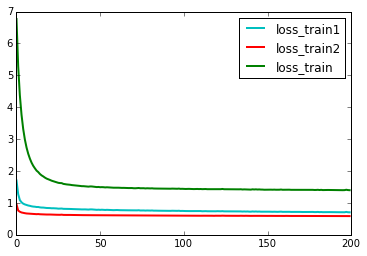

In [12]:
plt.plot(all_losses_train_1, 'c', all_losses_train_2, 'r', all_losses_train, 'g', linewidth=2.0)
plt.legend(("loss_train1", "loss_train2", "loss_train"))

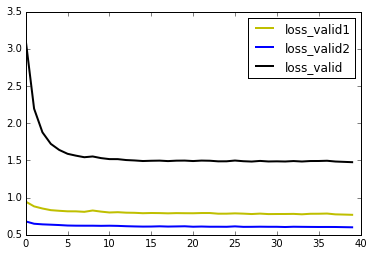

In [13]:
plt.plot(all_losses_valid_1, 'y', all_losses_valid_2, 'b', all_losses_valid, 'k', linewidth=2.0)
plt.legend(("loss_valid1", "loss_valid2", "loss_valid"))

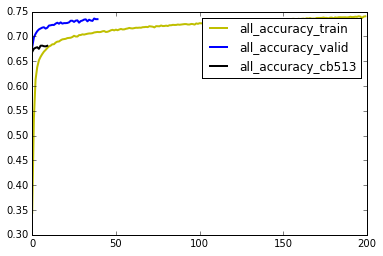

In [14]:
plt.plot(all_accuracy_train_1, 'y', all_accuracy_valid_1, 'b', all_accuracy_cb513_1, 'k', linewidth=2.0)
plt.legend(("all_accuracy_train", "all_accuracy_valid", "all_accuracy_cb513"))